# **Introduction**

In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained PyTorch RetinaNet Object Detection For Inference on Test Images.


### **Setting up Colab :**

In [1]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [2]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

     |████████████████████████████████| 510 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB 2.9 MB/s 
     |████████████████████████████████| 829 kB 13.1 MB/s 
     |████████████████████████████████| 117 kB 17.0 MB/s 
Found existing installation: torchtext 0.13.1
Uninstalling torchtext-0.13.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchtext-0.13.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchtext/*
Proceed (y/n)? y
  Successfully uninstalled torchtext-0.13.1
Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 2137, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 2137 (delta 56), reused 32 (delta 15), pack-reused 2032
Receiving objects: 100% (2137/2137), 84.65 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (1406/1406), done.


In [3]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[BCCD Dataset](https://public.roboflow.com/object-detection/bccd)** from RoboFlow. There are 364 images across three classes.


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Blank")
project = rf.workspace("kwangwoon-university-p0uws").project("test-nynmz")
dataset = project.version(2).download("coco")

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 673 kB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 145 kB 63.0 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 138 kB 68.0 MB/s 
     |████████████████████████████████| 178 kB 69.1 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=b7b022757016dbdf0f7a7e2abe97deefcb52a52b62785c7597ed518bead95cee
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installati

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to test-2 in coco::   0%|          | 0/2764 [00:00<?, ?it/s]
Extracting Dataset Version Zip to test-2 in coco::   5%|▌         | 148/2764 [00:00<00:01, 1479.61it/s]
Extracting Dataset Version Zip to test-2 in coco::  11%|█         | 296/2764 [00:00<00:02, 946.78it/s] 
Extracting Dataset Version Zip to test-2 in coco::  15%|█▍        | 402/2764 [00:00<00:02, 858.00it/s]
Extracting Dataset Version Zip to test-2 in coco::  18%|█▊        | 494/2764 [00:00<00:02, 829.68it/s]
Extracting Dataset Version Zip to test-2 in coco::  21%|██        | 580/2764 [00:00<00:02, 752.85it/s]
Extracting Dataset Version Zip to test-2 in coco::  24%|██▍       | 665/2764 [00:00<00:02, 777.24it/s]
Extracting Dataset Version Zip to test-2 in coco::  27%|██▋       | 745/2764 [00:00<00:02, 757.59it/s]
Extracting Dataset Version Zip to test-2 in coco::  32%|███▏      | 883/2764 [00:01<00:02, 924.73it/s]
Extracting Dataset Version Zip to test-2 in coco::  35%|███▌      | 979/2764 [00:

In [ ]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/train/"
VALID_ANNOT_PATH = "/content/valid/"
TEST_ANNOT_PATH  = "/content/test/"

In [ ]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [ ]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **CSV Files are as follows :**

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/train/img514_jpg.rf.762c4767ac492e8e04697a569de2f4e4.jpg,640,640,0,225,80,369,318,1
1,/content/train/img477_jpg.rf.939261c044d38580bb1459d9d60124b7.jpg,640,640,1,303,327,543,541,2
2,/content/train/img477_jpg.rf.939261c044d38580bb1459d9d60124b7.jpg,640,640,1,65,232,315,538,2
3,/content/train/img9_jpg.rf.5b8a805bbc1e23864c25481c54fbaba4.jpg,640,640,1,225,136,513,454,2
4,/content/train/img592_jpg.rf.4c0ba5d86865a9c0d541a80e51050bd8.jpg,640,640,0,50,150,390,516,1


In [ ]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/valid/img955_jpg.rf.c1c3b227715ea124683fd5cdbcb9ee5d.jpg,640,640,1,174,115,414,433,2
1,/content/valid/img1069_jpg.rf.9ad74543256bd23065b8f693280a0323.jpg,640,640,1,73,164,213,362,2
2,/content/valid/img1069_jpg.rf.9ad74543256bd23065b8f693280a0323.jpg,640,640,1,294,219,380,299,2
3,/content/valid/img412_jpg.rf.12fd28b191f7c89ee9fc54d210a5425a.jpg,640,640,0,51,1,537,555,1
4,/content/valid/img1271_jpg.rf.1ff154759fd4d7b2592d635014b4e7e6.jpg,640,640,1,4,132,478,534,2


In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/test/img1310_jpg.rf.664d1552e855572dd83a82f0247f5ed4.jpg,640,640,1,45,180,315,610,2
1,/content/test/img1310_jpg.rf.664d1552e855572dd83a82f0247f5ed4.jpg,640,640,1,459,204,549,416,2
2,/content/test/img523_jpg.rf.1ed2838e78209af41fc769306fe1abd8.jpg,640,640,0,170,414,302,582,1
3,/content/test/img523_jpg.rf.1ed2838e78209af41fc769306fe1abd8.jpg,640,640,0,342,322,444,532,1
4,/content/test/img523_jpg.rf.1ed2838e78209af41fc769306fe1abd8.jpg,640,640,0,1,111,97,301,1


In [ ]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [ ]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 0, 1, 2]

##**Plot images with Bounding boxes over them**:

In [ ]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.  
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

### **Image from Train Data:**

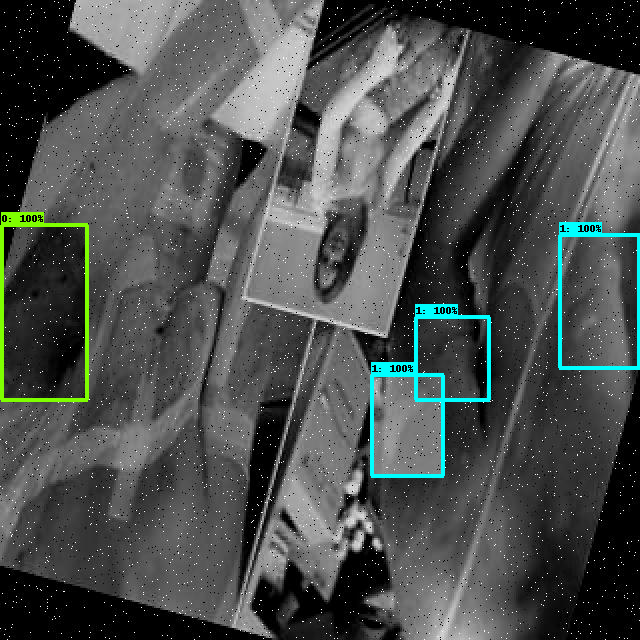

In [ ]:
image = load_image_from_data(train_df, index=10)
image

### **Image from Validation data:**

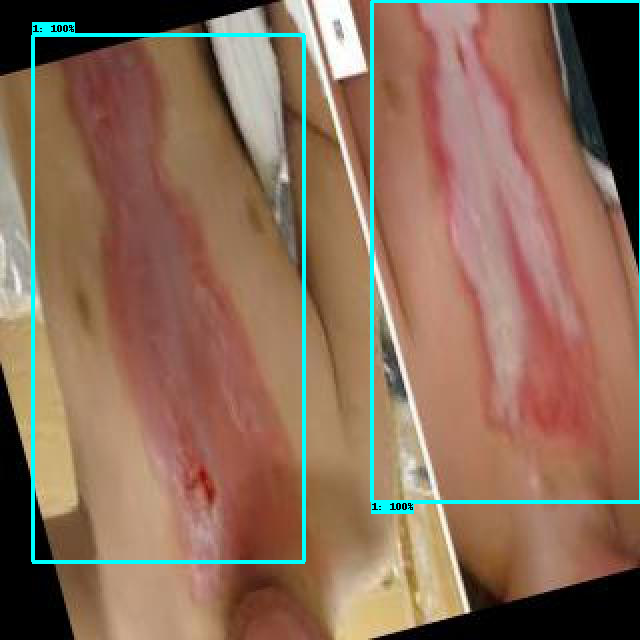

In [ ]:
image = load_image_from_data(valid_df, index=10)
image

###**Image from Test Data:**

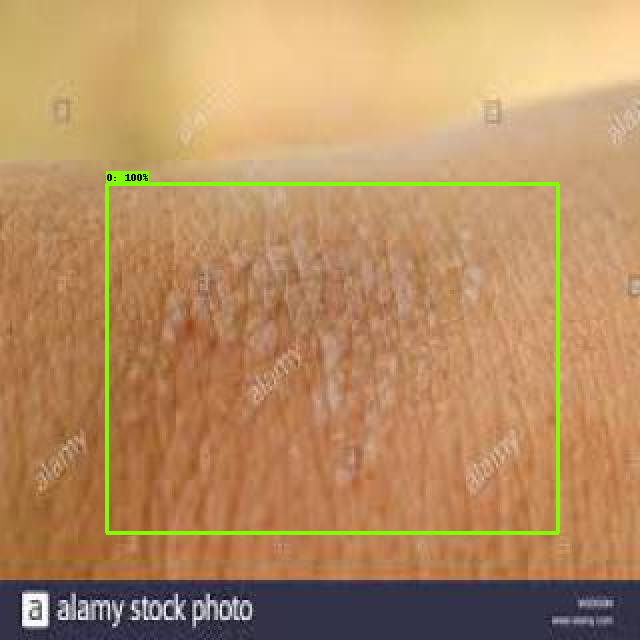

In [ ]:
image = load_image_from_data(test_df, index=5)
image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :

The configuration file is present in `/content/pytorch_retinanet/hparams.yaml`.


In [ ]:
NUM_TRAIN_EPOCHS = 50


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 1
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP) - 1 
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR", 
    "params"     : {"T_max": NUM_TRAIN_EPOCHS}, 
    "monitor"    : None, 
    "interval"   : "epoch", 
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 3
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 50
  monitor: null
  interval: epoch
  frequency: 1



#**Instantiate Lightning-Module and Lightning-Trainer**

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from model import RetinaNetModel

# seed so that results are reproducible
pl.seed_everything(123)

123

## **Load in the Lighning-Trainer :**

In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)

GPU available: True, used: True
INFO:retinanet.models:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:retinanet.models:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:retinanet.models:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:retinanet.models:Using native 16bit precision.


##**Load in the Lighning-Module using the hparams file modified above & Start Train :**

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 3
INFO:retinanet.models:NUM_CLASSES  : 3


In [ ]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  
INFO:retinanet.models:
  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
trainer.test(litModel)

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

[{'AP': 0.3938117048034073}]

# **Export the model weights** :

In [ ]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
import logging
logger = logging.getLogger("lightning")

In [ ]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 3
